In [2]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.linear_model import Lasso

Import all the data

In [3]:
train_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
test_df = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")
holev = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")
oil = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
stores = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
transactions = pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv")
pd.set_option('display.max_columns',None)

Let's create different variables from datetime

In [4]:
for dataframe in [train_df, test_df]:
    dataframe['date'] = pd.to_datetime(dataframe['date'])
    dataframe['day_week'] = dataframe['date'].dt.day_of_week
    dataframe['day'] = dataframe['date'].dt.day
    dataframe['month'] = dataframe['date'].dt.month
    dataframe['year'] = dataframe['date'].dt.year

Let's Merge all the datasets

In [5]:
#we use the store number in order to get all the informations into train and test set
train_df = train_df.merge(stores, on = 'store_nbr', how = 'left')
test_df = test_df.merge(stores, on = 'store_nbr', how = 'left')

In [6]:
transactions['date'] = pd.to_datetime(transactions['date'])

In [7]:
#let's add the number of transactions by date and store number
train_df = train_df.merge(transactions, on = ['date', 'store_nbr'],how='left')
test_df = test_df.merge(transactions, on = ['date', 'store_nbr'],how='left')

In [8]:
oil = oil.dropna()

In [9]:
oil['date'] = pd.to_datetime(oil['date'])

In [10]:
#let's add the oil daily cost 
train_df = train_df.merge(oil, on = 'date',how='left')
test_df = test_df.merge(oil, on = 'date',how='left')

In [11]:
#if the transaction has nulls let's consider it at 0, so that day there hasn't been any transaction
train_df.loc[train_df['transactions'].isnull(),'transactions'] = 0.0
test_df.loc[test_df['transactions'].isnull(),'transactions'] = 0.0

In [12]:
holev['date'] = pd.to_datetime(holev['date'])

In [13]:
#if the holiday is transferred, let's consider it as a workday
holev.loc[(holev['transferred']==True)&(holev['type']=='Holiday'), holev['type']]='Work'

# Holidays
Since the holidays are of 3 different kind (National, Regional and Ciy) we addss the problem by getting all the national holidays and then merge it by the date.
Same process for regional and city.

In [14]:
df_national_holidays = holev[holev['locale'] == 'National']
train_df = train_df.merge(df_national_holidays[['date', 'type']], on='date', how='left', suffixes=('', '_national'))
test_df = test_df.merge(df_national_holidays[['date', 'type']], on='date', how='left', suffixes=('', '_national'))

In [15]:
df_regional_holidays = holev[holev['locale'] == 'Regional']
train_df = train_df.merge(df_regional_holidays[['date', 'type', 'locale_name']], 
                          left_on=['date', 'state'], right_on=['date', 'locale_name'], 
                          how='left', suffixes=('', '_regional'))
test_df = test_df.merge(df_regional_holidays[['date', 'type', 'locale_name']], 
                          left_on=['date', 'state'], right_on=['date', 'locale_name'], 
                          how='left', suffixes=('', '_regional'))

In [16]:
df_local_holidays = holev[holev['locale'] == 'Local']
train_df = train_df.merge(df_local_holidays[['date', 'type', 'locale_name']], 
                          left_on=['date', 'city'], right_on=['date', 'locale_name'], 
                          how='left', suffixes=('', '_local'))
test_df = test_df.merge(df_local_holidays[['date', 'type', 'locale_name']], 
                          left_on=['date', 'city'], right_on=['date', 'locale_name'], 
                          how='left', suffixes=('', '_local'))

In [17]:
train_df['holiday_type'] = train_df['type_national'].combine_first(train_df['type_regional']).combine_first(train_df['type_local'])
test_df['holiday_type'] = test_df['type_national'].combine_first(test_df['type_regional']).combine_first(test_df['type_local'])

In [18]:
train_df.drop(columns=['type_national', 'type_regional', 'type_local', 'locale_name','locale_name_local'], inplace=True)
test_df.drop(columns=['type_national', 'type_regional', 'type_local', 'locale_name','locale_name_local'], inplace=True)

In [19]:
train_df['holiday_type'] = train_df['holiday_type'].fillna('Work')
test_df['holiday_type'] = test_df['holiday_type'].fillna('Work')

In [20]:
#helper function to create lag features
def add_lag_features(lag,feature,data,new_feature):
    for l in range(lag):
        data[str(new_feature+'_'+str(l+1))] = data[str(feature)].shift(l+7)
    return data

In [21]:
train_df.set_index('date', inplace=True)
df_weekly = train_df['sales'].resample('W').mean().dropna()

# Corregplot
Let's visualize the lags by week

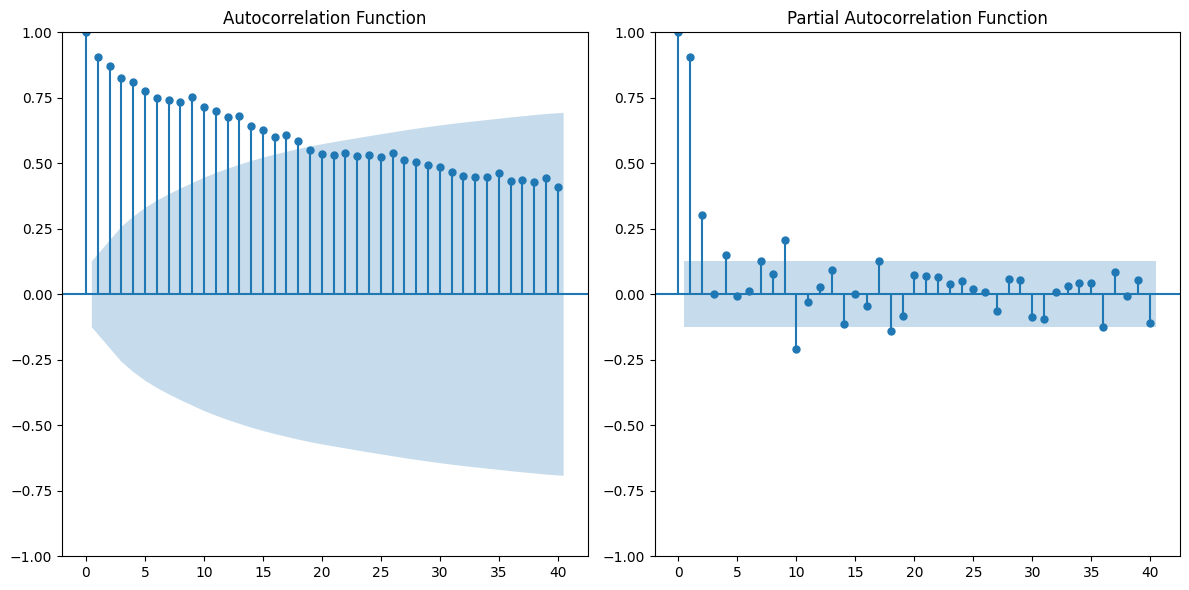

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(df_weekly, lags=40, ax=plt.gca())
plt.title('Autocorrelation Function')

plt.subplot(122)
plot_pacf(df_weekly, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

# Creating Dummies

In [23]:
train_df = pd.get_dummies(data = train_df, columns=['store_nbr', 'family', 'type','holiday_type', 'city', 'state', 'cluster','day_week','month'], drop_first=True)

In [24]:
test_df = pd.get_dummies(data=test_df, columns=['store_nbr', 'family', 'type', 'holiday_type', 'city', 'state', 'cluster', 'day_week', 'month'], drop_first=True)

In [25]:
#let's reallign the test set with the train set since dummification can cause disallignments
test_df = test_df.reindex(columns=train_df.columns, fill_value=0)
test_df = test_df.fillna(0)

In [26]:
#let's correct the problem with months
test_df.loc[:,'month_8'] = 1

In [27]:
add_lag_features(lag=11,feature='sales',data = train_df, new_feature='lag')

,id,sales,onpromotion,day,year,transactions,dcoilwtico,store_nbr_2,store_nbr_3,store_nbr_4,store_nbr_5,store_nbr_6,store_nbr_7,store_nbr_8,store_nbr_9,store_nbr_10,store_nbr_11,store_nbr_12,store_nbr_13,store_nbr_14,store_nbr_15,store_nbr_16,store_nbr_17,store_nbr_18,store_nbr_19,store_nbr_20,store_nbr_21,store_nbr_22,store_nbr_23,store_nbr_24,store_nbr_25,store_nbr_26,store_nbr_27,store_nbr_28,store_nbr_29,store_nbr_30,store_nbr_31,store_nbr_32,store_nbr_33,store_nbr_34,store_nbr_35,store_nbr_36,store_nbr_37,store_nbr_38,store_nbr_39,store_nbr_40,store_nbr_41,store_nbr_42,store_nbr_43,store_nbr_44,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,family_EGGS,family_FROZEN FOODS,family_GROCERY I,family_GROCERY II,family_HARDWARE,family_HOME AND KITCHEN I,family_HOME AND KITCHEN II,family_HOME APPLIANCES,family_HOME CARE,family_LADIESWEAR,family_LAWN AND GARDEN,family_LINGERIE,"family_LIQUOR,WINE,BEER",family_MAGAZINES,family_MEATS,family_PERSONAL CARE,family_PET SUPPLIES,family_PLAYERS AND ELECTRONICS,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,type_B,type_C,type_D,type_E,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer,holiday_type_Work,holiday_type_Work Day,city_Babahoyo,city_Cayambe,city_Cuenca,city_Daule,city_El Carmen,city_Esmeraldas,city_Guaranda,city_Guayaquil,city_Ibarra,city_Latacunga,city_Libertad,city_Loja,city_Machala,city_Manta,city_Playas,city_Puyo,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,state_Bolivar,state_Chimborazo,state_Cotopaxi,state_El Oro,state_Esmeraldas,state_Guayas,state_Imbabura,state_Loja,state_Los Rios,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,day_week_1,day_week_2,day_week_3,day_week_4,day_week_5,day_week_6,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0,0.000,0,1,2013,0.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-01,1,0.000,0,1,2013,0.0,NaN,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fal

In [28]:
train_df = train_df.dropna(subset=['lag_'+str(i+1) for i in range(11)])

In [29]:
train_df = train_df.drop(columns=['lag_4','lag_6','lag_7','lag_8','lag_9'])

In [30]:
np.shape(train_df)

(3008263, 177)

In [31]:
np.shape(test_df)

(28512, 171)

In [ ]:
#All the dummies are boolean, let's make it binary
train_df.iloc[:,7:-6] = train_df.iloc[:,7:-6].astype(int)
test_df.iloc[:,7:] = test_df.iloc[:,7:].astype(int)

In [33]:
df = train_df.copy()

In [34]:
df = df.dropna()

In [35]:
#let's drop the sales column given by the reallignment after dummification
test_df = test_df.drop(columns = ['sales'])

In [36]:
X = df.drop(columns=['id','sales'])
y = df['sales']

In [37]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [38]:
columns_to_standardize = ['onpromotion', 'transactions','dcoilwtico','lag_1','lag_2','lag_3','lag_5','lag_10','lag_11']

In [39]:
X[columns_to_standardize] = scaler_x.fit_transform(X[columns_to_standardize])

In [40]:
y = scaler_y.fit_transform(y.values.reshape(-1,1))

In [41]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size = 0.3,random_state=123)

In [42]:
alpha = 0.1
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train)
y_train_predicted = lasso.predict(X_train)
y_val_predicted = lasso.predict(X_val)

In [43]:
y_train_predicted[y_train_predicted < 0] = 0.0

In [44]:
y_val_predicted[y_val_predicted < 0] = 0.0

In [45]:
train_msle = mean_squared_log_error(y_train, y_train_predicted)
test_msle = mean_squared_log_error(y_val, y_val_predicted)

In [46]:
print(f"MSE su training set: {train_msle:.8f}")
print(f"MSE su test set: {test_msle:.8f}")

MSE su training set: 0.00005662
MSE su test set: 0.00005769


In [47]:
#let's transform the test msle in a non standardized form
scaler_y.inverse_transform(test_msle.reshape(-1,1))

array([[7.19487996]])

In [48]:
#let's refit the minmax scaler not using the lags
X_temp = X.copy()
columns_to_standardize = ['onpromotion', 'transactions','dcoilwtico']
X_temp[columns_to_standardize] = scaler_x.fit_transform(X_temp[columns_to_standardize])

In [49]:
test_df[columns_to_standardize] = scaler_x.transform(test_df[columns_to_standardize])

In [50]:
test_df['dcoilwtico'] = test_df['dcoilwtico'].fillna(np.mean(test_df['dcoilwtico']))

In [51]:
#helper function for iterative forecast. 
def iterative_forecast(model, training, test):
    predictions = []
    
    # let's create the lag columns
    for lag in [1, 2, 3, 5, 10, 11]:
        test[f'lag_{lag}'] = None
    
    # Iteration on the dataset
    for i in range(len(test)):
        for lag in [1, 2, 3, 5, 10, 11]:
            if i < lag * 7:
                # here we use the real values in the training set
                lag_value = training['sales'].iloc[len(training) - lag * 7 + i] if (len(training) - lag * 7 + i) >= 0 else None
            else:
                # here we use the predicted values
                lag_value = predictions[i - lag * 7] if (i - lag * 7) >= 0 else None
            
            test.at[i, f'lag_{lag}'] = lag_value
        
        # let's create the dataframe for the current row
        current_lag = test.iloc[i:i+1].drop(columns=['sales'], errors='ignore')
        
        # let's predict and append the result to the list
        value = model.predict(current_lag)[0] 
        predictions.append(value)
        
    return predictions

In [52]:
test_ids = test_df['id']
test_df = test_df.drop(columns = ['id'])

In [54]:
predictions = iterative_forecast(lasso, df, test_df)

/tmp/ipykernel_33/3802449770.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[f'lag_{lag}'] = None
/tmp/ipykernel_33/3802449770.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[f'lag_{lag}'] = None
/tmp/ipykernel_33/3802449770.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[f

In [55]:
# let's invert the scaling to get the real values of the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))

/tmp/ipykernel_33/2941649787.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df['predicted_sales'] = predictions


In [66]:
test_ids = np.ravel(test_ids)
predictions = np.ravel(predictions)

In [69]:
submission = pd.DataFrame({'id': test_ids, 'sales': predictions})
submission.to_csv('submission.csv', index=False)